## Spatial Features Vs Urban Footprint Vs Population Size

Steps: 

    1) read zonal stats for spatial features (Independent vars) and GUF (Dependent var)
    2) merge the two files with id
    3) Locate the dependant and Independent variables (exclude columns like name)
    4) Standardize the dataset with μ=0 and σ=1  (using StandardScaler from sklearn)
    5) Run Pearson Correlation (Dependent vs Independent vars)
    6) Create a new dataset by selecting those independent variables with high statistical signficance 
    7) Split the new dataset into train(2/3) and test(1/3) sets
    7) Run Elastic Net with 10 fold cross validation
    
    

In [63]:
import sklearn
import pandas as pd
import numpy as np
import csv
import scipy.stats as stats
from statistics import pstdev
from statistics import mean
from sklearn import preprocessing
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.datasets import make_regression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from itertools import product
import copy
import geopandas as gpd

### Read the Features data

In [3]:
spfeas = pd.read_excel('blz_spfeas_v3.xlsx', sheet_name=0)
spfeas['OBJECTID'] = spfeas['OBJECTID'].astype(int)
spfeas = spfeas.set_index('OBJECTID')
spfeas.head()

,FID,Administra,Administ_1,Area,Urban_Rura,CTV_2018,ED_2018,Cluster_Nu,fourier_sc31_variance_mean,fourier_sc31_variance_std,...,sfs_sc51_std_sum,sfs_sc71_max_ratio_of_orthgonal_angles_mean,sfs_sc71_max_ratio_of_orthgonal_angles_std,sfs_sc71_max_ratio_of_orthgonal_angles_sum,sfs_sc31_std_mean,sfs_sc31_std_std,sfs_sc31_std_sum,sfs_sc71_min_line_length_mean,sfs_sc71_min_line_length_std,sfs_sc71_min_line_length_sum
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,0,Toledo District,BLZ006,Toledo Rural,Rural,Cayes,217,665,1.871010,4.929879,...,42799652.0,140.709890,1.065200,4286729472,1.193974,1.408849,36374452.0,874775.350589,330970.948840,26650047676400
2,1,Stann Creek District,BLZ005,Stann Creek Rural,Rural,Cayes,201,602,2.608672,6.141846,...,92699568.0,140.376936,4.624142,7790784512,1.375928,1.689124,76362680.0,824859.818661,380083.243379,45778923946000
3,2,NaN,NaN,NaN,NaN,Cayes,126,0,6.380702,8.840365,...,10851945.0,139.219940,8.347895,461388384,2.413110,2.699090,7997279.0,614737.965726,486655.097810,2037301248000
4,3,NaN,NaN,NaN,NaN,Cayes,122,0,2.894536,6.357571,...,65703932.0,139.365071,12.484677,5233991680,1.457598,1.841355,54741532.0,814288.179976,388871.179731,30581389787100
5,4,NaN,NaN,NaN,NaN,Cayes,123,0,4.566548,7.459406,...,44759044.0,140.065461,2.836504,2403786496,1.953999,2.401075,33534290.0,692178.805971,461589.477238,11879088914400


In [4]:
print(spfeas.columns)

Index(['FID', 'Administra', 'Administ_1', 'Area', 'Urban_Rura', 'CTV_2018',
       'ED_2018', 'Cluster_Nu', 'fourier_sc31_variance_mean',
       'fourier_sc31_variance_std',
       ...
       'sfs_sc51_std_sum', 'sfs_sc71_max_ratio_of_orthgonal_angles_mean',
       'sfs_sc71_max_ratio_of_orthgonal_angles_std',
       'sfs_sc71_max_ratio_of_orthgonal_angles_sum', 'sfs_sc31_std_mean',
       'sfs_sc31_std_std', 'sfs_sc31_std_sum', 'sfs_sc71_min_line_length_mean',
       'sfs_sc71_min_line_length_std', 'sfs_sc71_min_line_length_sum'],
      dtype='object', length=440)


### Load GUF

In [97]:
#guf = pd.read_csv('blz_guf.csv')
guf = gpd.read_file('shapefiles/Belize.shp')
guf['OBJECTID'] = guf['OBJECTID'].astype(int)
guf = guf.set_index('OBJECTID')
guf.head()

,Administra,Administ_1,Area,Urban_Rura,CTV_2018,ED_2018,Cluster_Nu,Shape_Leng,Shape_Area,guf_count,guf_sum,guf_mean,geometry
OBJECTID,,,,,,,,,,,,,
1,Toledo District,BLZ006,Toledo Rural,Rural,Cayes,217,665,294022.358507,2.934572e+09,19997649.0,15555.0,0.000778,"POLYGON ((399920.6887999997 1810189.0381, 3749..."
2,Stann Creek District,BLZ005,Stann Creek Rural,Rural,Cayes,201,602,431082.304407,5.345558e+09,29936453.0,105315.0,0.003518,"POLYGON ((394993.4018999999 1890194.2018, 4199..."
3,None,None,None,None,Cayes,126,0,69417.179782,3.192064e+08,2201594.0,57375.0,0.026061,"POLYGON ((396450.5060999999 1932268.1654, 3874..."
4,None,None,None,None,Cayes,122,0,247650.430790,3.617347e+09,24922037.0,6120.0,0.000246,"POLYGON ((409999.5525000002 1960194.1161, 4299..."
5,None,None,None,None,Cayes,123,0,240469.134053,1.652992e+09,11387124.0,205530.0,0.018049,"POLYGON ((380605.6778999995 1947417.0743, 3804..."


### Percent of Built up

In [98]:
guf['PCNT_blt'] = ((guf['guf_sum']/255)*144)/(guf['Shape_Area'])*100

## Belize City

In [99]:
bc= guf[guf['Area']=='Belize City']


In [100]:
stats.describe(guf['PCNT_blt'])

DescribeResult(nobs=723, minmax=(0.0, 101.98502107390833), mean=32.165901801514025, variance=1375.2440097226054, skewness=0.6624761998824099, kurtosis=-1.2189252972618094)

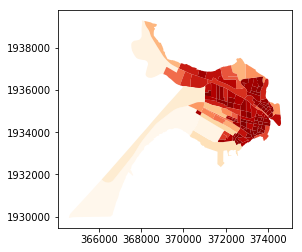

In [101]:

bc.plot(column='PCNT_blt', cmap='OrRd');


### Merge population data with urbanfootprint and featuures

In [108]:
guf_cols =guf.drop(['geometry'],axis=1)
spfeas_guf = spfeas.merge(guf_cols, left_on='OBJECTID', right_on="OBJECTID", how='outer')

In [109]:
spfeas_guf = spfeas_guf.round(3)
spfeas_guf.head()

,FID,Administra_x,Administ_1_x,Area_x,Urban_Rura_x,CTV_2018_x,ED_2018_x,Cluster_Nu_x,fourier_sc31_variance_mean,fourier_sc31_variance_std,...,Urban_Rura_y,CTV_2018_y,ED_2018_y,Cluster_Nu_y,Shape_Leng,Shape_Area,guf_count,guf_sum,guf_mean,PCNT_blt
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,0,Toledo District,BLZ006,Toledo Rural,Rural,Cayes,217,665,1.871,4.930,...,Rural,Cayes,217,665,294022.359,2.934572e+09,19997649.0,15555.0,0.001,0.000
2,1,Stann Creek District,BLZ005,Stann Creek Rural,Rural,Cayes,201,602,2.609,6.142,...,Rural,Cayes,201,602,431082.304,5.345558e+09,29936453.0,105315.0,0.004,0.001
3,2,NaN,NaN,NaN,NaN,Cayes,126,0,6.381,8.840,...,None,Cayes,126,0,69417.180,3.192064e+08,2201594.0,57375.0,0.026,0.010
4,3,NaN,NaN,NaN,NaN,Cayes,122,0,2.895,6.358,...,None,Cayes,122,0,247650.431,3.617347e+09,24922037.0,6120.0,0.000,0.000
5,4,NaN,NaN,NaN,NaN,Cayes,123,0,4.567,7.459,...,None,Cayes,123,0,240469.134,1.652992e+09,11387124.0,205530.0,0.018,0.007


### Filter Dataset by Builtup Surface. 

Select Rows where  builtup is greater than or equal to 10 percent

In [110]:
#filter_by_builtup.shape

In [111]:
spfeas_guf.shape

(723, 453)

### Analysis

Get the list of dependent variables from the DataFrame to store in list y_vars

In [112]:
#y_var = list(filter_by_builtup.axes[1])[440]

y_var = list(spfeas_guf.axes[1])[452]
y_var

'PCNT_blt'

Get a list of all independent variables from the DataFrame in list all_x

In [113]:
all_x = list(spfeas_guf.axes[1])[8:440]

#Check
all_x

['fourier_sc31_variance_mean',
 'fourier_sc31_variance_std',
 'fourier_sc31_variance_sum',
 'fourier_sc71_mean_mean',
 'fourier_sc71_mean_std',
 'fourier_sc71_mean_sum',
 'fourier_sc51_mean_mean',
 'fourier_sc51_mean_std',
 'fourier_sc51_mean_sum',
 'fourier_sc31_mean_mean',
 'fourier_sc31_mean_std',
 'fourier_sc31_mean_sum',
 'fourier_sc51_variance_mean',
 'fourier_sc51_variance_std',
 'fourier_sc51_variance_sum',
 'fourier_sc71_variance_mean',
 'fourier_sc71_variance_std',
 'fourier_sc71_variance_sum',
 'gabor_sc3_filter_5_mean',
 'gabor_sc3_filter_5_std',
 'gabor_sc3_filter_5_sum',
 'gabor_sc3_filter_4_mean',
 'gabor_sc3_filter_4_std',
 'gabor_sc3_filter_4_sum',
 'gabor_sc3_filter_7_mean',
 'gabor_sc3_filter_7_std',
 'gabor_sc3_filter_7_sum',
 'gabor_sc3_filter_6_mean',
 'gabor_sc3_filter_6_std',
 'gabor_sc3_filter_6_sum',
 'gabor_sc3_filter_1_mean',
 'gabor_sc3_filter_1_std',
 'gabor_sc3_filter_1_sum',
 'gabor_sc3_mean_mean',
 'gabor_sc3_mean_std',
 'gabor_sc3_mean_sum',
 'gabor_sc

### Compute Coorelation of features with population density

Store all features with the least correlation (stat. significance (p < 0.05)) 

The Pearson correlation coefficient **measures the linear relationship
between two datasets.** Strictly speaking, Pearson's correlation requires
that each dataset be **normally distributed, and not necessarily zero-mean.**

Like other correlation coefficients, this one varies between -1 and +1
with 0 implying no correlation. Correlations of -1 or +1 imply an exact
linear relationship. Positive correlations imply that as x increases, so
does y. Negative correlations imply that as x increases, y decreases.

The p-value roughly indicates **the probability of an uncorrelated system**
producing datasets that have a Pearson correlation at least as extreme
as the one computed from these datasets. 

***The p-values are not entirely
reliable but are probably reasonable for datasets larger than 500 or so.***

In [114]:
spfeas_guf[y_var] = spfeas_guf[y_var].fillna(0)
spfeas_guf[y_var].isnull().values.any()

False

In [115]:
y_dict = {}
x = []

for x_var in all_x:
    
    #Calculate the Pearson statistics, 
    # returns the Pearson value and p value
    
    p = stats.skew(spfeas_guf[x_var])
    
    #print(y_var, x_var, p)
    # print back for mike
    #print (y_var + " , " + x_var + " , " +  p)

In [116]:
y_dict = {}
x = []

for x_var in all_x:
    
    #Calculate the Pearson statistics, 
    # returns the Pearson value and p value
    
    p = stats.pearsonr(spfeas_guf[x_var],spfeas_guf[y_var])
    
    #print back for mike
    #print (y_var + " , " + x_var + " , " +  str(p[0]) + " , " + str(p[1]))
    
    #If p < 0.05 append to list x
    if p[1] < 0.05:
        x.append([x_var,(p[0])])

#List x is made into a DataFrame 
# which is sorted by the absolute values of the Pearson values
x_df = pd.DataFrame(x,columns=["x_var","abs_r2"]).sort_values("abs_r2",ascending=True)


#The dependent variable dictionary is given an entry 
# where the key is the name of the dependent variable
# and the value is a list of top 200 most significant values

y_dict[y_var] = list(x_df["x_var"][0:200])
#y_dict[y_var]
#Print out each dependent variable and 
#the number of x values that remain to check completion

In [117]:
x_df.head(10)

,x_var,abs_r2
205,hog_sc3_mean_std,-0.857618
393,sfs_sc71_mean_std,-0.855711
416,sfs_sc51_std_std,-0.855463
196,hog_sc3_variance_std,-0.854911
384,sfs_sc51_max_line_length_std,-0.851919
401,sfs_sc51_mean_std,-0.847721
377,sfs_sc31_max_ratio_of_orthgonal_angles_mean,-0.847523
181,hog_sc3_skew_std,-0.842375
390,sfs_sc71_max_line_length_std,-0.840047
187,hog_sc5_variance_std,-0.837114


In [118]:
#check 

for key in y_dict.keys():
    print(key,len(y_dict[key]))


PCNT_blt 200


### Correlation Significance

For each dependent variable y in the list of all dependent values, calibrate the model.
Add new key to the output dictionary where y is the dependent variable curently being processed and the values are empty for now

In [119]:
#Initialize the output dictionary, Y_D, 
# with each key being a dependent variable and the values being the results of the analyses

Y_D = {}

Y_D[y_var]={}

#Dictionary Models is used to store each result object for later use if needed

Models ={}

#Get independent variables from the variable dictionary and store in list x_vars
x_vars = y_dict[y_var]


vars_df = pd.DataFrame()

vars_df[y_var] = spfeas_guf[y_var]


for x in x_vars:
    vars_df[x] = spfeas_guf[x]

In [120]:
vars_df.head()

,PCNT_blt,hog_sc3_mean_std,sfs_sc71_mean_std,sfs_sc51_std_std,hog_sc3_variance_std,sfs_sc51_max_line_length_std,sfs_sc51_mean_std,sfs_sc31_max_ratio_of_orthgonal_angles_mean,hog_sc3_skew_std,sfs_sc71_max_line_length_std,...,ndvi_sc7_variance_sum,gabor_sc3_filter_6_sum,lsr_sc31_line_contrast_sum,gabor_sc3_filter_14_sum,gabor_sc3_filter_4_sum,gabor_sc3_variance_sum,gabor_sc3_filter_2_sum,lsr_sc71_line_mean_sum,lsr_sc51_line_mean_sum,lsr_sc31_line_mean_sum
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,0.000,0.030,3.611,2.171,0.020,8.963,2.139,59.940,260.562,14.701,...,88283.445,4268226.0,352244.812,4190443.25,4270674.5,4252190.0,4301633.50,903582.750,592044.062,303744.344
2,0.001,0.034,3.900,2.543,0.021,10.370,2.498,59.794,306.419,15.847,...,212219.297,14678573.0,1978046.625,14700483.00,14730628.0,14851798.0,14907193.00,3488723.250,2422398.750,1369010.625
3,0.010,0.050,6.270,4.127,0.031,15.748,4.135,59.375,457.526,21.978,...,62153.355,2312857.5,295803.500,2388331.25,2333564.5,2398271.0,2380358.25,288316.938,225190.719,144002.234
4,0.000,0.037,4.205,2.718,0.023,10.530,2.726,59.360,329.783,16.090,...,317034.562,8461734.0,1125579.250,8523885.00,8505262.0,8616366.0,8615760.00,1914274.500,1352945.625,762789.312
5,0.007,0.044,5.750,3.668,0.028,14.556,3.617,59.771,388.974,21.460,...,200005.656,7058029.0,514777.219,7238431.50,7125290.5,7291112.5,7265922.50,1384077.625,880130.625,421985.594


### Scale/Normalize Data

In [121]:
#minmax_scaler = preprocessing.MinMaxScaler()
standard_scaler = preprocessing.StandardScaler()

names = vars_df.columns
scaled_df = standard_scaler.fit_transform(vars_df)
scaled_df = pd.DataFrame(scaled_df, columns=names)
scaled_df.head()

/Users/eddiebedada/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/eddiebedada/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,PCNT_blt,hog_sc3_mean_std,sfs_sc71_mean_std,sfs_sc51_std_std,hog_sc3_variance_std,sfs_sc51_max_line_length_std,sfs_sc51_mean_std,sfs_sc31_max_ratio_of_orthgonal_angles_mean,hog_sc3_skew_std,sfs_sc71_max_line_length_std,...,ndvi_sc7_variance_sum,gabor_sc3_filter_6_sum,lsr_sc31_line_contrast_sum,gabor_sc3_filter_14_sum,gabor_sc3_filter_4_sum,gabor_sc3_variance_sum,gabor_sc3_filter_2_sum,lsr_sc71_line_mean_sum,lsr_sc51_line_mean_sum,lsr_sc31_line_mean_sum
0,-0.867974,0.228516,-0.442054,-1.010173,-1.098023,-0.642303,-1.153309,1.375263,-2.128305,-0.004390,...,0.271410,4.057015,-0.036085,3.970109,4.039343,3.989964,4.026619,0.619569,0.341245,0.081083
1,-0.867947,0.425437,-0.303468,-0.697011,-0.977374,-0.337376,-0.863187,1.272099,-1.478262,0.163301,...,0.986434,14.554479,0.898106,14.545867,14.535469,14.549255,14.559289,3.065607,2.108028,1.146003
2,-0.867704,1.213121,0.833038,0.636455,0.229116,0.828153,0.459734,0.976030,0.663748,1.060433,...,0.120658,2.085283,-0.068516,2.156729,2.095534,2.143097,2.118548,0.037409,-0.012867,-0.078607
3,-0.867974,0.573127,-0.157208,-0.549690,-0.736076,-0.302700,-0.678932,0.965431,-1.147066,0.198858,...,1.591145,8.285615,0.408275,8.330647,8.288574,8.337540,8.311096,1.575877,1.075719,0.539979
4,-0.867785,0.917739,0.583678,0.250053,-0.132831,0.569821,0.041119,1.255847,-0.308007,0.984636,...,0.915970,6.870164,0.057307,7.037156,6.903831,7.017328,6.970535,1.074209,0.619325,0.199286


### Scale the variables

### Set Elastic net's parameters

In [125]:
enet_result = ElasticNetCV(max_iter=1e8,
                    alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1],
                    l1_ratio =[.1, .5, .7, .9, .95, .99, 1],
                    verbose= False,
                    n_jobs = -1, 
                    cv=5, 
                    selection = 'random',
                    fit_intercept=False)


In [126]:
scaled_df.shape

(723, 201)

In [127]:
# Fit the mode

In [128]:
#Fit the model with the scaled data
enet_result.fit(scaled_df[x_vars],scaled_df[y_var])
#Append the model to the Models dictionary
Models[y_var] = enet_result


In [129]:
enet_result

ElasticNetCV(alphas=[0.0005, 0.001, 0.01, 0.03, 0.05, 0.1], copy_X=True, cv=5,
       eps=0.001, fit_intercept=False,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=100000000.0,
       n_alphas=100, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='random',
       tol=0.0001, verbose=False)

In [130]:
opt_alpha, opt_l1_ratio = enet_result.alpha_, enet_result.l1_ratio_

#Print update to ensure that the script is progressing properly
print("R2: {:.2f} Alpha: {} l1_ratio: {}"
      .format(enet_result.score(scaled_df[x_vars],scaled_df[y_var]),
              enet_result.alpha_, enet_result.l1_ratio_))

R2: 0.87 Alpha: 0.01 l1_ratio: 0.7


Record the overall R squared score and optimal alpha 
and l1 ratio values and store them in the output dictionary


In [131]:
Y_D[y_var]['Total R2'] = enet_result.score(scaled_df[x_vars],scaled_df[y_var])
Y_D[y_var]['Alpha'] = opt_alpha
Y_D[y_var]['l1_ratio'] = opt_l1_ratio

### Ten Fold Cross validated regression

In [132]:
#Create a list R2s to store out of sample R squared values

R2s = []

#Specify the number of trials to run

trials = 10

#Run the number of trials specified in trials, 
#for each trial 66% of the observations are randomly selected to train the model
#Testing is done on the remaining 33% of observations and the R squared values are recorded

for i in range(trials):    
    X_train, X_test, y_train, y_test = train_test_split(scaled_df[x_vars],scaled_df[y_var], test_size=0.34)
    enet_regr = ElasticNetCV(max_iter=1e8,
                    alphas = [opt_alpha],
                    l1_ratio =[opt_l1_ratio],
                    n_jobs = -1, 
                    cv=5, 
                    selection = 'random',
                    fit_intercept=False)
    enet_regr.fit(X_train,y_train)
    R2s.append(enet_regr.score(X_test,y_test))

#print("Mean R2: {:.2f} StDev: {:.4f}".format(mean(R2s),pstdev(R2s)))
#Record the out of sample R squared values
Y_D[y_var]['Sampling']={'trials':trials,'R2':mean(R2s),'StDev':pstdev(R2s),'R2s':R2s}
#coefs = [i for i in zip(list(scaled_df[x_vars].axes[1]),enet_result.coef_)]
#remaining = [i for i in coefs if abs(i[1])>0.0]
#Y_D[y_var]["Coefficients"]=remaining

In [133]:
Y_D[y_var]

{'Total R2': 0.8668784969976561,
 'Alpha': 0.01,
 'l1_ratio': 0.7,
 'Sampling': {'trials': 10,
  'R2': 0.8568017577253242,
  'StDev': 0.0168979417911759,
  'R2s': [0.8409250788005442,
   0.8453593113329914,
   0.8500741266886311,
   0.8396243207443851,
   0.8647765214949126,
   0.8890640757798818,
   0.8645778903585172,
   0.8684101972046523,
   0.8725672916540925,
   0.8326387631946339]}}

In [134]:
y_df = pd.DataFrame([i for i in zip(list(scaled_df[x_vars].axes[1]),enet_result.coef_)], 
                    columns=["features","Coeff"]).sort_values("Coeff", ascending=False)

y_df.head(25)

,features,Coeff
177,lbpm_sc7_max_mean,0.148238
84,lbpm_sc3_max_std,0.134117
82,sfs_sc51_max_ratio_of_orthgonal_angles_std,0.057339
54,lbpm_sc5_mean_std,0.008124
73,lsr_sc31_line_mean_std,0.005917
133,gabor_sc7_filter_11_sum,-0.000000
126,gabor_sc7_filter_9_sum,-0.000000
127,gabor_sc3_filter_9_sum,-0.000000
128,gabor_sc7_filter_7_sum,-0.000000
129,mean_sc7_mean_sum,-0.000000


# Result

At national Scale, with GUF we can explain, 86% varriation of built up surface/human settlement



HOG, NDIV, SFS and MEAN are significant

## HOG

In [135]:
filter_var = [col for col in scaled_df if col.startswith('hog')]
X_train, X_test, y_train, y_test = train_test_split(scaled_df[filter_var],scaled_df[y_var], test_size=0.34)
enet_result.fit(X_train,y_train)

Models[y_var] = enet_result

opt_alpha, opt_l1_ratio = enet_result.alpha_, enet_result.l1_ratio_


print("R2: {:.2f} Alpha: {} l1_ratio: {}"
      .format(enet_result.score(scaled_df[filter_var],scaled_df[y_var]),
              enet_result.alpha_, enet_result.l1_ratio_))


R2: 0.81 Alpha: 0.0005 l1_ratio: 1.0


## GABOR

In [136]:
filter_var = [col for col in scaled_df if col.startswith('gabor')]
X_train, X_test, y_train, y_test = train_test_split(scaled_df[filter_var],scaled_df[y_var], test_size=0.34)
enet_result.fit(X_train,y_train)

Models[y_var] = enet_result

opt_alpha, opt_l1_ratio = enet_result.alpha_, enet_result.l1_ratio_


print("R2: {:.2f} Alpha: {} l1_ratio: {}"
      .format(enet_result.score(scaled_df[filter_var],scaled_df[y_var]),
              enet_result.alpha_, enet_result.l1_ratio_))

R2: -0.02 Alpha: 0.03 l1_ratio: 0.5


## LBPM

In [137]:
filter_var = [col for col in scaled_df if col.startswith('lbpm')]
X_train, X_test, y_train, y_test = train_test_split(scaled_df[filter_var],scaled_df[y_var], test_size=0.34)
enet_result.fit(X_train,y_train)

Models[y_var] = enet_result

opt_alpha, opt_l1_ratio = enet_result.alpha_, enet_result.l1_ratio_


print("R2: {:.2f} Alpha: {} l1_ratio: {}"
      .format(enet_result.score(scaled_df[filter_var],scaled_df[y_var]),
              enet_result.alpha_, enet_result.l1_ratio_))

R2: 0.79 Alpha: 0.001 l1_ratio: 0.5
